In [108]:
from pyspark.sql import SparkSession
from pathlib import Path
import pyspark.sql.functions as func
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum
from pyspark.sql.window import Window


def read_parquet_file(spark, file_path):
    df = spark.read.parquet(file_path)
    return df


def is_hdfs_file_exist(path):
    proc = subprocess.Popen(['hadoop', 'fs', '-test', '-e', path])
    proc.communicate()
    return proc.returncode == 0


def add_index_to_dataframe(df):
    return df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))



spark = SparkSession.builder.appName('lr_example').getOrCreate()

# Load data
hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"
case_file_dest = "case_daily_summary.parquet"

all_data = read_parquet_file(spark, hdfs_host+hdfs_root_path+case_file_dest)
all_data.printSchema()



root
 |-- date: string (nullable = true)
 |-- dailyConfirmed: integer (nullable = true)
 |-- falsePositiveFound: integer (nullable = true)
 |-- cumulativeConfirmed: integer (nullable = true)
 |-- dailyDischarged: integer (nullable = true)
 |-- passedButNotDueToCovid: integer (nullable = true)
 |-- cumulativeDischarged: integer (nullable = true)
 |-- dischargedToIsolation: integer (nullable = true)
 |-- stillHospitalized: integer (nullable = true)
 |-- dailyDeaths: integer (nullable = true)
 |-- cumulativeDeaths: integer (nullable = true)
 |-- testedPositiveDemise: integer (nullable = true)
 |-- dailyImported: integer (nullable = true)
 |-- dailyLocalTransmission: integer (nullable = true)
 |-- localCaseResidingInDorms: integer (nullable = true)
 |-- localCaseNotResidingInDorms: integer (nullable = true)
 |-- intensiveCareUnitCases: integer (nullable = true)
 |-- generalWardsMOHReport: integer (nullable = true)
 |-- inIsolationMOHReport: integer (nullable = true)
 |-- totalCompletedIsol

In [109]:
cases_group_by_date = all_data["date","dailyConfirmed","cumulativeConfirmed",
                               "dailyImported","localCaseNotResidingInDorms","localCaseResidingInDorms"]\
                      .withColumn("dayOfWeek", func.dayofweek(all_data["date"]))\
                      .na.fill(0)
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()
cases_group_by_date.printSchema()

+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dailyImported|localCaseNotResidingInDorms|localCaseResidingInDorms|dayOfWeek|index|
+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+
|2020-01-23|             1|                  1|            1|                          0|                       0|        5|    1|
|2020-01-24|             2|                  3|            2|                          0|                       0|        6|    2|
|2020-01-25|             1|                  4|            1|                          0|                       0|        7|    3|
|2020-01-26|             0|                  4|            0|                          0|                       0|        1|    4|
|2020-01-27|             1|                  5|            1|                      

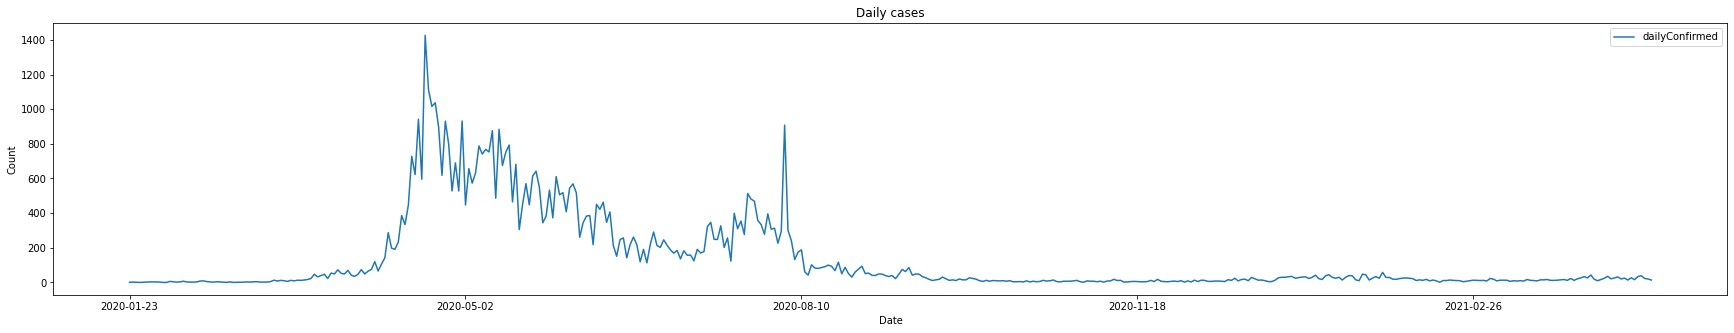

In [110]:
cases_group_by_date.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (30,5)

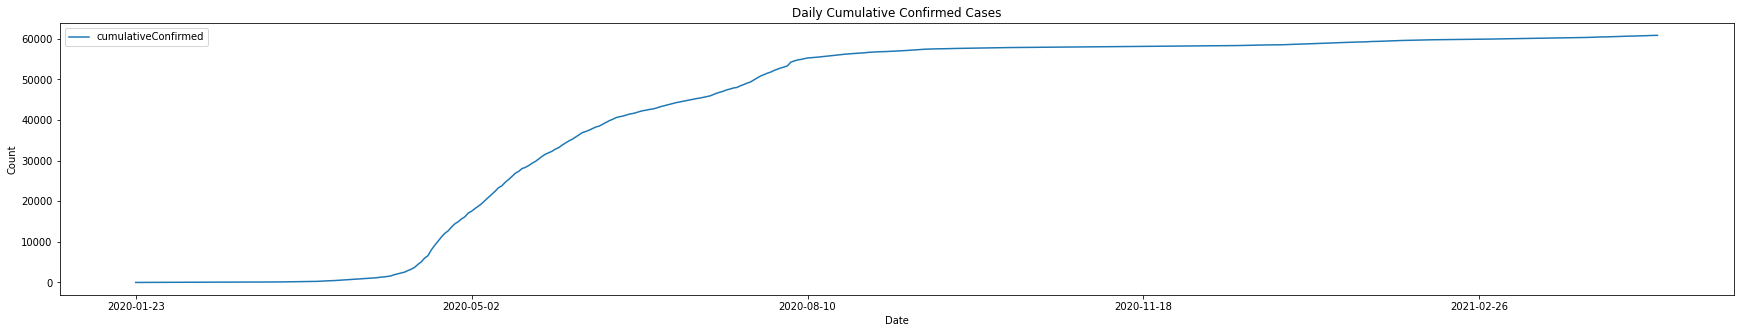

In [111]:
cases_group_by_date.toPandas().plot(x="date", y="cumulativeConfirmed")
plt.title("Daily Cumulative Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (30,5)

+---------+-------------------+
|dayOfWeek|sum(dailyConfirmed)|
+---------+-------------------+
|        1|               8866|
|        2|               8128|
|        3|               8157|
|        4|               9574|
|        5|               8735|
|        6|               9212|
|        7|               8273|
+---------+-------------------+



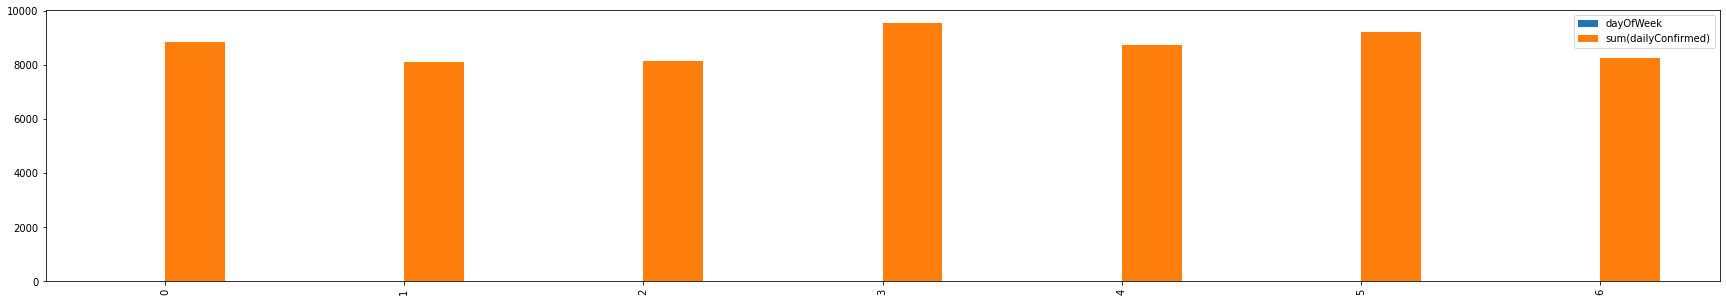

In [96]:

#cases_group_by_date.select("count").distinct().show()
cases_group_by_day_of_week = cases_group_by_date\
                        .groupby(['dayOfWeek'])\
                        .agg(_sum('dailyConfirmed'))\
                        .orderBy('dayOfWeek',asending=True)
cases_group_by_day_of_week.show()

cases_group_by_day_of_week.toPandas().plot(kind='bar')
plt.rcParams["figure.figsize"] = (5,5)

root
 |-- Case Type: string (nullable = true)
 |-- Count: long (nullable = true)

+------------------------+-----+
|Case Type               |Count|
+------------------------+-----+
|Imported Cases          |3978 |
|Local Transmission Cases|2471 |
|Local Case Reside Dorms |54146|
+------------------------+-----+



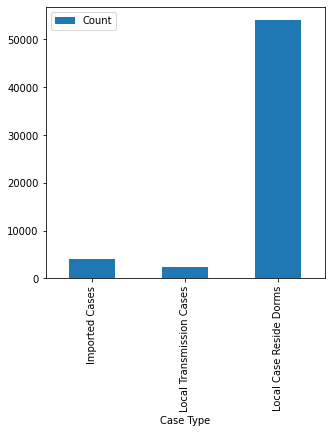

In [97]:

case_categories_columns = ["Case Type","Count"]
case_categories = [("Imported Cases",cases_group_by_date.groupBy().sum('dailyImported').collect()[0][0]), 
        ("Local Transmission Cases",cases_group_by_date.groupBy().sum('localCaseNotResidingInDorms').collect()[0][0]), 
        ("Local Case Reside Dorms",cases_group_by_date.groupBy().sum('localCaseResidingInDorms').collect()[0][0])]
case_categories_df = spark.createDataFrame(data=case_categories, schema = case_categories_columns)
case_categories_df.printSchema()
case_categories_df.show(truncate=False)

case_categories_df.toPandas().plot.bar(x="Case Type")
plt.rcParams["figure.figsize"] = (5,5)

In [106]:
cases_group_by_date=cases_group_by_date.filter(cases_group_by_date["Date"]>='2020-09-15').drop("index","dailyImported","localCaseNotResidingInDorms","localCaseResidingInDorms")
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()

+----------+--------------+-------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dayOfWeek|index|
+----------+--------------+-------------------+---------+-----+
|2020-09-15|            34|              57488|        3|    1|
|2020-09-16|            27|              57514|        4|    2|
|2020-09-17|            18|              57532|        5|    3|
|2020-09-18|            11|              57543|        6|    4|
|2020-09-19|            15|              57558|        7|    5|
|2020-09-20|            18|              57576|        1|    6|
|2020-09-21|            31|              57606|        2|    7|
|2020-09-22|            21|              57627|        3|    8|
|2020-09-23|            12|              57639|        4|    9|
|2020-09-24|            15|              57654|        5|   10|
|2020-09-25|            11|              57665|        6|   11|
|2020-09-26|            20|              57685|        7|   12|
|2020-09-27|            15|             

In [99]:
# Split into training data and test data
total_count = cases_group_by_date.count()
print(total_count)
seventy_percent_index = round(total_count * 0.7)
cases_group_by_date.registerTempTable("daily_cases")
train_data = spark.sql("select * from daily_cases where index <= {}".format(seventy_percent_index))
test_data = spark.sql("select * from daily_cases where index > {}".format(seventy_percent_index))
train_data.orderBy(desc("index")).show()
test_data.show()

454
+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dailyImported|localCaseNotResidingInDorms|localCaseResidingInDorms|dayOfWeek|index|
+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+
|2020-12-05|            13|              58255|           12|                          1|                       0|        7|  318|
|2020-12-04|             3|              58242|            3|                          0|                       0|        6|  317|
|2020-12-03|             9|              58239|            8|                          0|                       1|        5|  316|
|2020-12-02|             2|              58230|            2|                          0|                       0|        4|  315|
|2020-12-01|            10|              58228|            8|                  

In [100]:
# These are the default values for the featuresCol, labelCol, predictionCol
vectorAssembler = VectorAssembler(inputCols=["index"], outputCol="features")
train_sub = vectorAssembler.transform(train_data)
test_sub = vectorAssembler.transform(test_data)

lr = LinearRegression(featuresCol='features',labelCol='cumulativeConfirmed',predictionCol='prediction_cumulativeConfirmed')
# Fit the model
lr_model = lr.fit(train_sub)
# Print the coefficients and intercept training data
print("Coefficients: {}".format(str(lr_model.coefficients)))
print("Intercept: {}".format(str(lr_model.intercept)))

Coefficients: [245.62760725356105]
Intercept: -4649.1253695215955


Text(0, 0.5, 'Count')

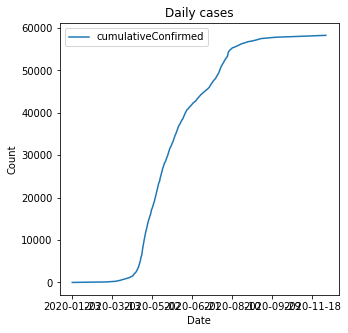

In [101]:
train_data.toPandas().plot(x="date", y="cumulativeConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")

In [102]:
# Testing result
test_result = lr_model.evaluate(test_sub)
test_result.residuals.show()
print("RMSE: {}".format(test_result.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
|-15446.081344364371|
| -15678.70895161794|
|-15912.336558871495|
|-16151.964166125064|
| -16391.59177337862|
|-16629.219380632174|
|-16866.846987885743|
|-17105.474595139298|
|-17346.102202392867|
|-17575.729809646422|
| -17809.35741689999|
|-18030.985024153546|
|-18267.612631407115|
| -18496.24023866067|
|-18722.867845914225|
|-18958.495453167794|
| -19175.12306042135|
|-19399.750667674918|
|-19632.378274928473|
|-19864.005882182042|
+-------------------+
only showing top 20 rows

RMSE: 31978.193641016736


In [103]:
# Prediction
predictions = lr_model.transform(test_sub)

predictions = predictions.withColumn("prediction_cumulativeConfirmed",func.round(predictions["prediction_cumulativeConfirmed"]))

### Defining the window 
Windowspec=Window.orderBy("index")

### Calculating lag of prediction_cumulativeConfirmed at each day level
predictions= predictions.withColumn('prev_day_prediction_cumulativeConfirmed',
                        func.lag(predictions['prediction_cumulativeConfirmed'])
                                .over(Windowspec))

### Calculating prediction_dailyConfirmed                                  
predictions = predictions.withColumn('prediction_dailyConfirmed', 
              predictions['prediction_cumulativeConfirmed'] - predictions['prev_day_prediction_cumulativeConfirmed'])



predictions.show()


+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+--------+------------------------------+---------------------------------------+-------------------------+
|      date|dailyConfirmed|cumulativeConfirmed|dailyImported|localCaseNotResidingInDorms|localCaseResidingInDorms|dayOfWeek|index|features|prediction_cumulativeConfirmed|prev_day_prediction_cumulativeConfirmed|prediction_dailyConfirmed|
+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+--------+------------------------------+---------------------------------------+-------------------------+
|2020-12-06|             5|              58260|            5|                          0|                       0|        1|  319| [319.0]|                       73706.0|                                   null|                     null|
|2020-12-07|            13|              58273|     

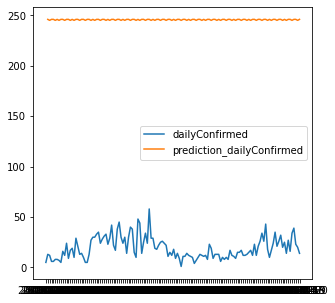

In [104]:
predictionsPandas = predictions.toPandas()

plt.plot( 'date', 'dailyConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction_dailyConfirmed', data=predictionsPandas, marker='')

# show legend
plt.legend()
# show graph
plt.show()


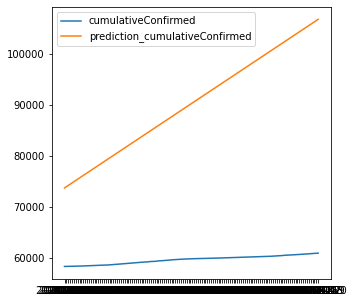

In [105]:
predictionsPandas = predictions.toPandas()

plt.plot( 'date', 'cumulativeConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction_cumulativeConfirmed', data=predictionsPandas, marker='')

# show legend
plt.legend()
# show graph
plt.show()
